# Unsupervised feature selection with global DIFFI

In this notebook we use unsupervised feature selection with global DIFFI described in the paper: [Interpretable Anomaly Detection with DIFFI: Depth-based Feature Importance for the Isolation Forest](https://arxiv.org/pdf/2007.11117.pdf).

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import DIFFI.interpretability_module as interp
from DIFFI.utils import *
from matplotlib.ticker import FuncFormatter

import data_processing as dp
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans

/Users/elnur/Desktop/Master_thesis/anomaly_detection_for_shared_mobility/adbike_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [2]:
bike_weather_data = dp.read_and_connect_data(city_name = 'boston', start = datetime(2023, 1, 1), end = datetime(2023, 1, 31))
bike_weather_data = dp.feature_engineering(bike_weather_data)
pca_bike_weather_data = dp.apply_pca(bike_weather_data)

### Get the feature ranking based on the global DIFFI method
We use $N_{fs}=5$.

In [4]:
X = bike_weather_data

In [5]:
# drop the month related columns as we are considering only January data
X = X.drop(columns=['end_month', 'start_month'])

In [7]:
sorted_idx = diffi_ranks(X, n_trees=100, max_samples=1024, n_iter=5)

In [11]:
X.columns[sorted_idx]

Index(['tripduration', 'prcp', 'distance', 'start_hour', 'coco', 'speed',
       'end_hour', 'wspd', 'temp', 'start_dayofweek', 'end_dayofweek',
       'user_type_encoded'],
      dtype='object')

### Train the Isolation Forest
We train the Isolation Forest by exploiting a variable number $k$ of features, ranging from $1$ to $p$ (where $p$ is the maximum number of available features, which depends on the selected dataset). For each value of $k$, we perform $n_{iter}=30$ runs of the algorithm, computing the median outlier score, the stability of the anomaly predictions (variance across runs), and the K-Means inertia. The Isolation Forest and K-Means are initialized with standard hyperparameters.

In [19]:
n_iter = 30
n_feats_max = X.shape[1]  
out_dict = {}
stability_dict = {}
kmeans_dict = {}

for n_feats in range(1, n_feats_max + 1):
    X_sel_feats = X.iloc[:, sorted_idx[:n_feats]]
    outlier_score_all = []
    stability_all = []
    kmeans_score_all = []

    for j in range(n_iter):
        iso_forest = IsolationForest(n_estimators=100, max_samples=1024, contamination='auto', random_state=j)
        iso_forest.fit(X_sel_feats)

        outlier_score = iso_forest.decision_function(X_sel_feats)
        outlier_score_all.append(outlier_score)

        preds = iso_forest.predict(X_sel_feats)
        stability_all.append(preds)

        kmeans = KMeans(n_clusters=2, random_state=j)
        clusters = kmeans.fit_predict(X_sel_feats)
        kmeans_score = kmeans.inertia_  # Using inertia as an overall measure of clustering
        kmeans_score_all.append(kmeans_score)

    out_dict[n_feats] = np.median(outlier_score_all)

    stability_all = np.array(stability_all)
    stability_dict[n_feats] = np.mean(np.var(stability_all, axis=0))  # Lower variance -> more stable predictions

    kmeans_dict[n_feats] = np.median(kmeans_score_all)


### Plot of average Outlier Scores, Stability (variance of anomaly labels), and K-Means Inertia as a function of the number of features

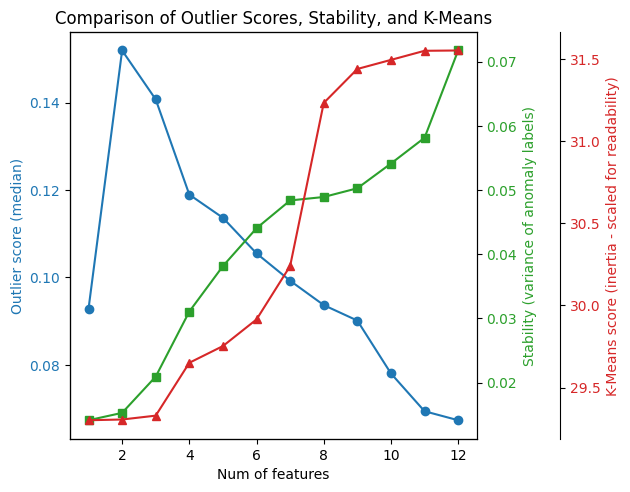

In [43]:
# Function and constant for readability of K-Means plot
large_constant = 1.4271e13

def kmeans_format(x, pos):
    return f'{(x - large_constant) / 1e7:.1f}' 

fig, ax1 = plt.subplots()

ax1.set_xlabel('Num of features')
ax1.set_ylabel('Outlier score (median)', color='tab:blue')
ax1.plot(list(out_dict.keys()), list(out_dict.values()), '-o', color='tab:blue', label='Outlier Score')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  
ax2.set_ylabel('Stability (variance of anomaly labels)', color='tab:green')  
ax2.plot(list(stability_dict.keys()), list(stability_dict.values()), '-s', color='tab:green', label='Stability')
ax2.tick_params(axis='y', labelcolor='tab:green')

ax3 = ax1.twinx()  
ax3.spines["right"].set_position(("outward", 60)) 
ax3.set_ylabel(f'K-Means score (inertia - scaled for readability)', color='tab:red')  
ax3.plot(list(kmeans_dict.keys()), list(kmeans_dict.values()), '-^', color='tab:red', label='K-Means')
ax3.tick_params(axis='y', labelcolor='tab:red')

ax3.yaxis.set_major_formatter(FuncFormatter(kmeans_format))

fig.tight_layout()  
plt.title('Comparison of Outlier Scores, Stability, and K-Means')
plt.show()


### Train IF with the best 9 features and visualize anomalies on the Duration and Distance dimension

In [44]:
iso_forest = IsolationForest(n_estimators=100, max_samples=1024, contamination='auto') 
X_sel_best_feats = X.iloc[:, sorted_idx[:9]]
bike_weather_data['anomaly'] = iso_forest.fit_predict(X_sel_best_feats)

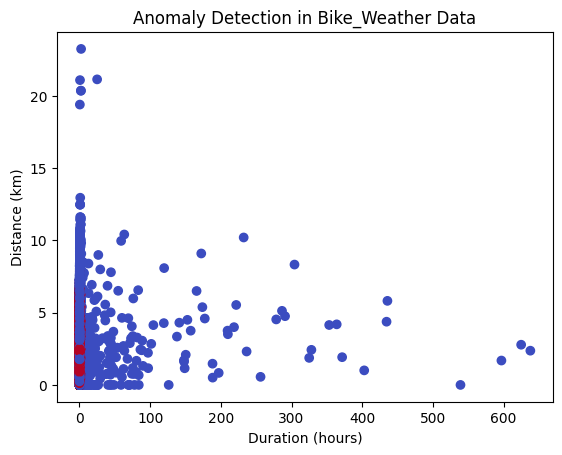

In [57]:
# Visualize the anomalies (1 = normal, -1 = anomaly)
plt.scatter(bike_weather_data['tripduration'] / 3600, bike_weather_data['distance'], c=bike_weather_data['anomaly'], cmap='coolwarm')

plt.xlabel('Duration (hours)')
plt.ylabel('Distance (km)')
plt.title('Anomaly Detection in Bike_Weather Data')
plt.show()

anomalies = bike_weather_data[bike_weather_data['anomaly'] == -1]


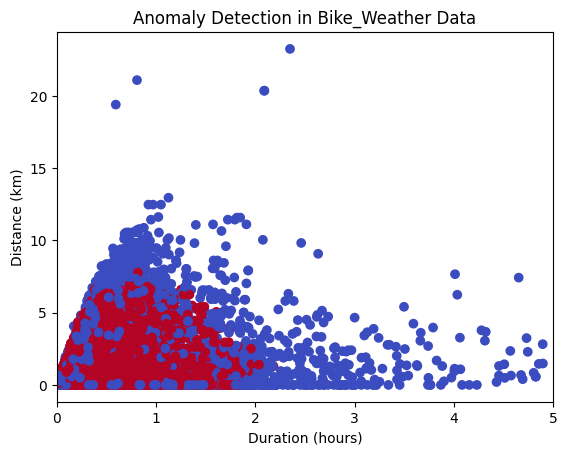

In [58]:
# Visualize the anomalies (1 = normal, -1 = anomaly)
plt.scatter(bike_weather_data['tripduration'] / 3600, bike_weather_data['distance'], c=bike_weather_data['anomaly'], cmap='coolwarm')

plt.xlim(0, 5)

plt.xlabel('Duration (hours)')
plt.ylabel('Distance (km)')
plt.title('Anomaly Detection in Bike_Weather Data')
plt.show()

In [49]:
print(anomalies.head())

   tripduration  distance  user_type_encoded     speed  temp  wspd  prcp  \
0           250  0.464383                  1  6.687112  11.1  13.0   1.2   
1           489  0.970031                  0  7.141336  11.1  13.0   1.2   
2           461  0.970031                  0  7.575083  11.1  13.0   1.2   
3          1065  0.585427                  0  1.978907  11.1  13.0   1.2   
4           601  1.136817                  1  6.809552  11.1  13.0   1.2   

   coco  start_hour  start_dayofweek  start_month  end_hour  end_dayofweek  \
0   7.0           0                6            1         0              6   
1   7.0           0                6            1         0              6   
2   7.0           0                6            1         0              6   
3   7.0           0                6            1         0              6   
4   7.0           0                6            1         0              6   

   end_month  anomaly  
0          1       -1  
1          1       -1  
2 

In [50]:
anomalies.shape

(15376, 15)

In [51]:
print(anomalies['coco'].mean())
print(bike_weather_data[bike_weather_data['anomaly'] == 1]['coco'].mean())

7.9784079084287205
3.5975400915463656
